# How many planets are left in the K2 Sample?

In [1]:
from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
import K2fov
import numpy as np
import pandas as pd

NEXSCI_API = 'http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI'

plt.style.use('ggplot')

In [2]:
# Grab the gaia/kepler crossmatch from Berger et al
hdu = fits.open('hlsp_kg-radii_kepler-gaia_multi_all_multi_v1_exo-cat.fits')
planets = Table(hdu[1].data).to_pandas()
hdu = fits.open('hlsp_kg-radii_kepler-gaia_multi_all_multi_v1_star-cat.fits')
stars = Table(hdu[1].data).to_pandas()
planets = planets.merge(stars, on='KIC_ID').reset_index(drop=True)

In [3]:
# Berger is missing some stars

#Cross match with DR25 from NexSci
len(stars)

177911

In [4]:
# Missing some planets too!
len(planets)

4045

In [5]:
# Jessie uses magnitude not temperature
# Jessie cuts out non-MS stars

In [6]:
kepler = pd.read_csv(NEXSCI_API + '?table=cumulative&select=*'
                 '&where=koi_disposition+like+%27C%25%27') 
columns = list(kepler.columns)
columns[0] = 'KIC_ID'
columns[1] = 'KOI_ID'
kepler.columns = columns
planets = planets.merge(kepler, on='KIC_ID')

In [7]:
# Get the K2 sample 
epic = Table(fits.open('/Users/ch/scratch/gaiadr2/notebooks/k2_dr2_1arcsec.fits')[1].data).to_pandas()
k2 = pd.read_csv(NEXSCI_API + '?table=k2candidates&select=*'
                 '&where=k2c_disp+like+%27C%25%27')  # +and+k2c_recentflag=1
k2['epic_number'] = [float(k.split('EPIC ')[-1]) for k in k2.epic_name]
k2 = k2.merge(epic, on='epic_number')

In [8]:
# Short period planets ONLY with transit depths > 200ppm

In [9]:
ok = (planets.koi_period < 20) & (planets.koi_depth > 200)

In [10]:
# Only the bright stuff in epic...
#k2 = k2[k2.k2_kepmag < 13]
#epic = epic[epic.k2_kepmag < 13]

Text(0,0.5,'Number of Exoplanets')

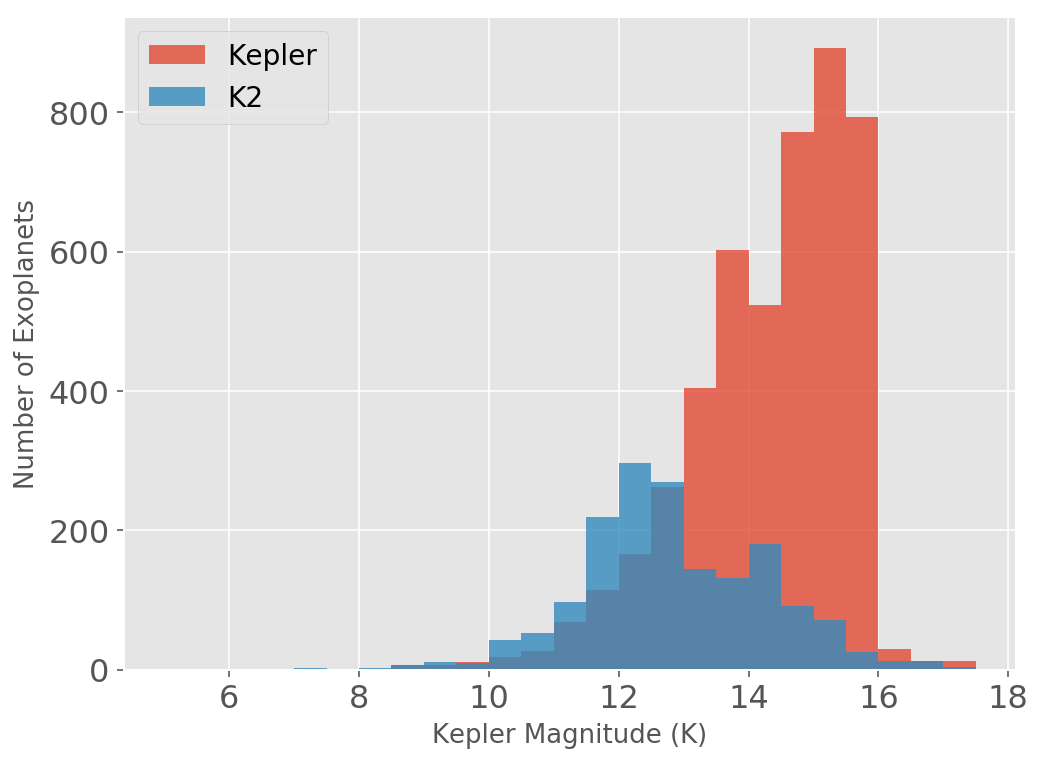

In [11]:
plt.figure(figsize=(8, 6))
h = plt.hist(kepler.koi_kepmag, np.arange(5, 18, 0.5), alpha=0.8, label='Kepler');
plt.hist(k2.k2_kepmag, h[1], alpha=0.8, label='K2');


plt.legend()
plt.xlabel('Kepler Magnitude (K)', fontsize=13)
plt.ylabel('Number of Exoplanets', fontsize=13)

Text(0,0.5,'Number of Targets')

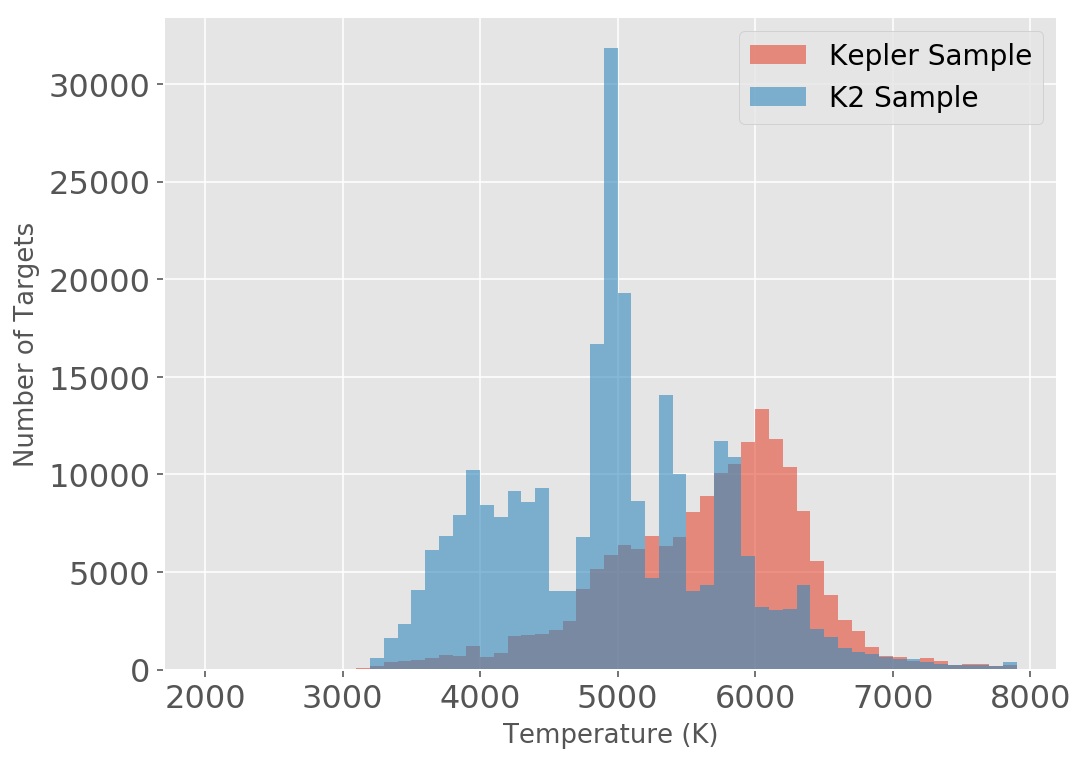

In [12]:
plt.figure(figsize=(8, 6))
h = plt.hist(stars.Teff, np.arange(2000, 8000, 100), alpha=0.6, label='Kepler Sample');
_ = plt.hist(epic.teff_val[np.isfinite(epic.teff_val)], h[1], alpha=0.6, label='K2 Sample');

plt.legend()
plt.xlabel('Temperature (K)', fontsize=13)
plt.ylabel('Number of Targets', fontsize=13)

Text(0,0.5,'Cumulative Density')

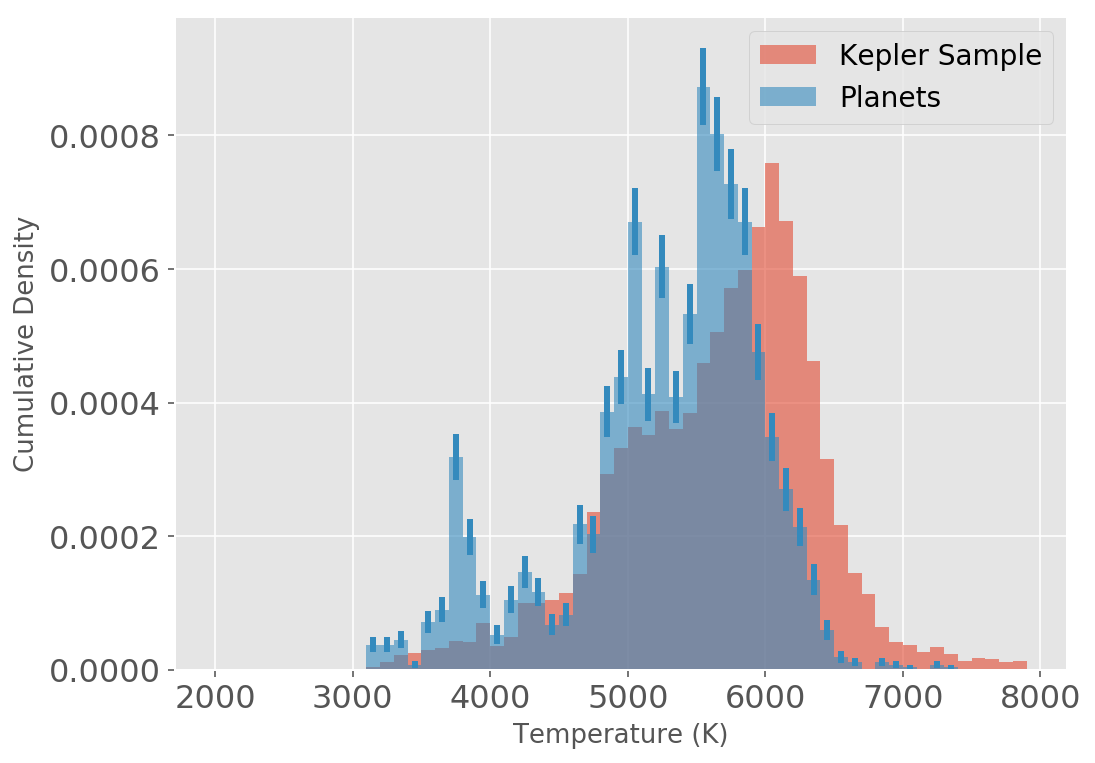

In [13]:
plt.figure(figsize=(8, 6))
h = plt.hist(stars.Teff, np.arange(2000, 8000, 100), density=True, alpha=0.6, label='Kepler Sample');
c = np.histogram(planets.loc[ok].Teff, h[1])[0]
_ = plt.hist(planets.loc[ok].Teff, h[1], density=True, alpha=0.6, label='Planets');
norm = np.trapz(c, h[1][1:] - np.diff(h[1]))
plt.errorbar(h[1][1:] - np.diff(h[1])//2, c/norm, c**0.5/norm, ls='', c='C1', lw=3)
plt.legend()
plt.xlabel('Temperature (K)', fontsize=13)
plt.ylabel('Cumulative Density', fontsize=13)

Text(0,0.5,'Cumulative Density')

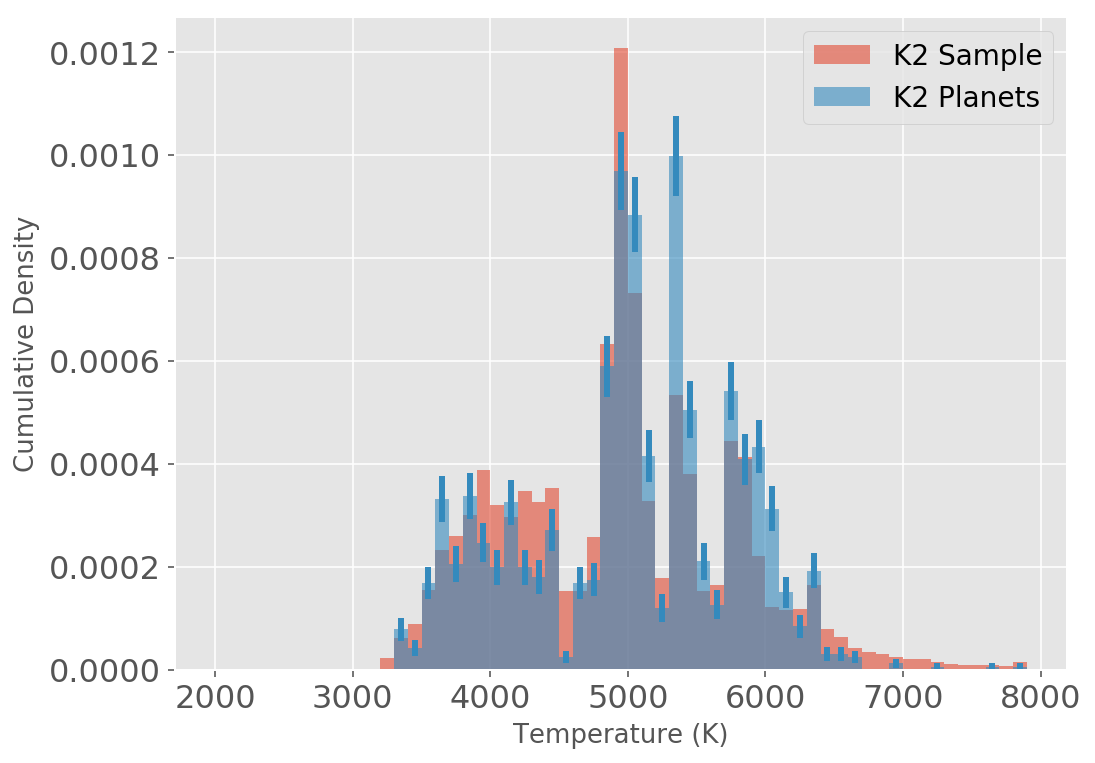

In [14]:
plt.figure(figsize=(8, 6))
h = plt.hist(epic.teff_val[np.isfinite(epic.teff_val)], np.arange(2000, 8000, 100), density=True, alpha=0.6, label='K2 Sample');
c = np.histogram(k2.teff_val[np.isfinite(k2.teff_val)], h[1])[0]
_ = plt.hist(k2.teff_val[np.isfinite(k2.teff_val)], h[1], density=True, alpha=0.6, label='K2 Planets');
norm = np.trapz(c, h[1][1:] - np.diff(h[1]))
plt.errorbar(h[1][1:] - np.diff(h[1])//2, c/norm, c**0.5/norm, ls='', c='C1', lw=3)
plt.legend()
plt.xlabel('Temperature (K)', fontsize=13)
plt.ylabel('Cumulative Density', fontsize=13)

In [15]:
fraction = np.zeros(len(h[1])) * np.nan
error = np.zeros(len(h[1])) * np.nan
for idx, b in enumerate(h[1]):
    ntarg = len(stars[(stars.Teff >= b) & (stars.Teff < b + 100)])
    if ntarg == 0:
        continue
    etarg = (ntarg ** 0.5)/ntarg
    nplan = len(planets[ok][(planets[ok].Teff >= b) & (planets[ok].Teff < b + 100)])
    if nplan == 0:
        eplan = 0
    else:
        eplan = (nplan ** 0.5)/nplan
    fraction[idx] = nplan/ntarg
    error[idx] = fraction[idx] * ((eplan ** 2) + (etarg ** 2))**0.5

In [16]:
k2_fraction = np.zeros(len(h[1])) * np.nan
k2_error = np.zeros(len(h[1])) * np.nan
for idx, b in enumerate(h[1]):
    ntarg = len(epic[(epic.teff_val >= b) & (epic.teff_val < b + 100)])
    if ntarg == 0:
        continue
    etarg = (ntarg ** 0.5)/ntarg
    nplan = len(k2[(k2.teff_val >= b) & (k2.teff_val < b + 100)])
    if nplan == 0:
        eplan = 0
    else:
        eplan = (nplan ** 0.5)/nplan
    k2_fraction[idx] = nplan/ntarg
    k2_error[idx] = k2_fraction[idx] * ((eplan ** 2) + (etarg ** 2))**0.5

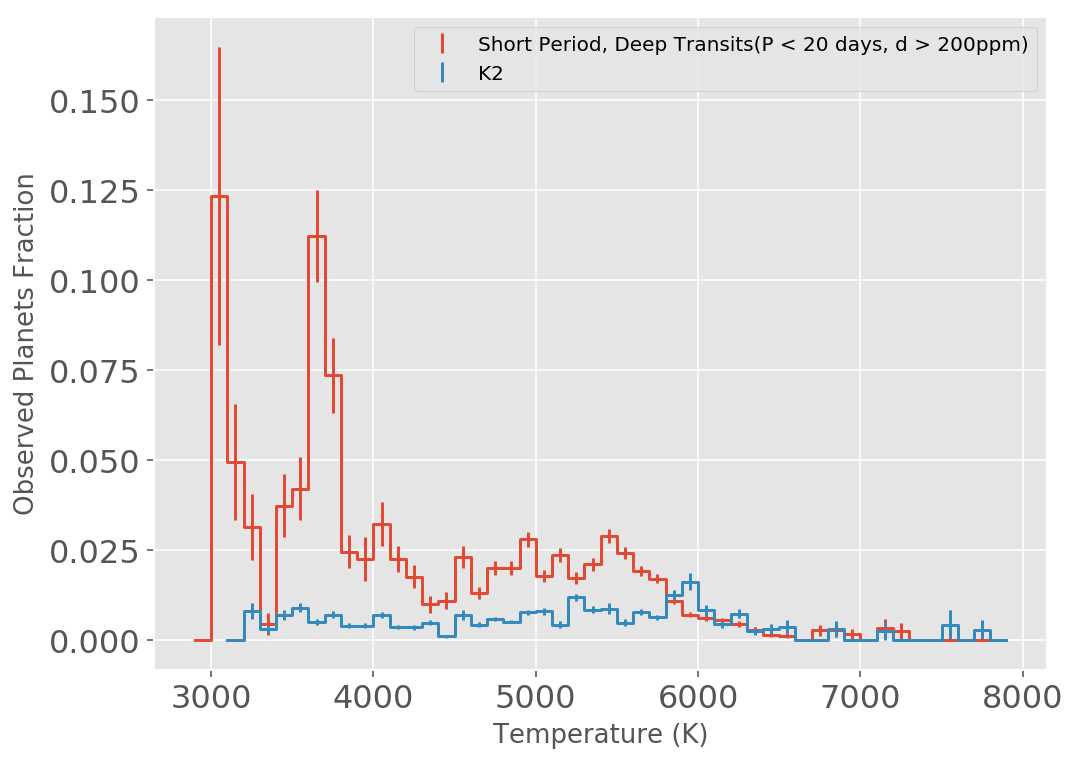

In [17]:
plt.figure(figsize=(8, 6))
plt.errorbar(h[1] - np.median(np.diff(h[1])//2), fraction, error, ls='', label='Short Period, Deep Transits(P < 20 days, d > 200ppm)')
plt.plot(h[1], fraction, linestyle='steps', color='C0')
plt.xlabel('Temperature (K)', fontsize=13)
plt.ylabel('Observed Planets Fraction', fontsize=13)


plt.errorbar(h[1] - np.median(np.diff(h[1])//2), k2_fraction, k2_error, ls='', label='K2')
plt.plot(h[1], k2_fraction, linestyle='steps', color='C1')
#plt.axhline((1/100), color='k', linestyle='--')
#plt.text(7000, 0.015, '1 in 100')
plt.legend(fontsize=10)

Text(0,0.5,'Cumulative Density')

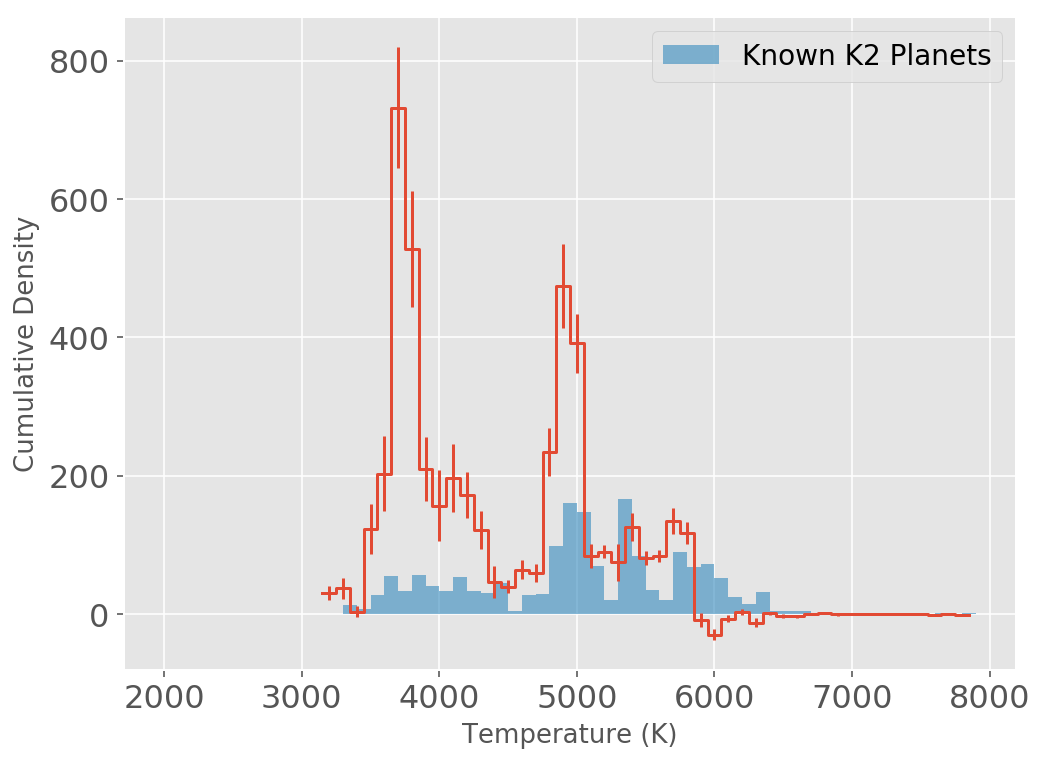

In [18]:
plt.figure(figsize=(8, 6))

c = np.histogram(epic.teff_val[np.isfinite(epic.teff_val)], h[1])[0]
plt.plot(h[1][:-1] + 50, (fraction - k2_fraction)[:-1] * c, linestyle='steps', c='C0')
plt.errorbar(h[1][:-1], (fraction - k2_fraction)[:-1] * c, (error**2 + k2_error**2)[:-1]**0.5 * c, ls='', c='C0') 


_ = plt.hist(k2.teff_val[np.isfinite(k2.teff_val)], h[1], density=False, alpha=0.6, label='Known K2 Planets', color='C1');
plt.legend()
plt.xlabel('Temperature (K)', fontsize=13)
plt.ylabel('Cumulative Density', fontsize=13)
